In [620]:
import pandas as pd
from causalinference import CausalModel
import seaborn as sns
import matplotlib.pyplot as plt

In [621]:
data_path = './data/Fichier Wake-Up v03.xlsx'

## Outcome variables:
anybleeding_all infarct_growth	MRS01   TICI_2b-3 asymptomatique_ICH Symptomatic_ICH sytemic_bleeding

In [622]:
outcome_var = 'sytemic_bleeding'

## Covariates

In [623]:
# Max 14 covariates
covar_fields = ['Age_(calc.)', 'Sex', 'Discovery_to_groin', 'Onset_to_groin_puncture_(min.)',
                'NIH_on_admission',
                'MedHist_Hypertension', 'MedHist_Diabetes', 'MedHist_Hyperlipidemia',
                'MedHist_Atrial_Fibr.', 'wake_up', 'T6', 'CBF', 'Localisation', 'ASPECTS']

if outcome_var == 'infarct_growth':
    # 9 covariates for infarct growth
    covar_fields = [ 'Discovery_to_groin', 'Onset_to_groin_puncture_(min.)',  'NIH_on_admission', 'wake_up',
                     'T6', 'CBF', 'Localisation', 'ASPECTS', 'Age_(calc.)']

## Intervention : IVT with rTPA

In [624]:
intervention_var = 'IVT_with_rtPA'

In [625]:

data = pd.read_excel(data_path)

data.columns = data.columns.str.replace(' ','_')

# Encode mRS (0 or 1) vs (> 1)
data['MRS01'] = data['3M_mRS'].isin([0, 1])

# Encode wake-up
data['wake_up'] = data['Time_of_symptom_onset_known'] == "wake up"

# Encode infarct growth
data['infarct_growth'] = data['lesion_volume_ml'] - data['CBF']
data.loc[data['infarct_growth'] < 0, 'infarct_growth'] = 0

# Encode TICI
data['TICI_2b-3'] = data['TICI_2b-3'].astype('int')

# Retain only relevant variables
data = data[covar_fields + [outcome_var, intervention_var]]



In [626]:
# Drop NaN (has to be done before one-hot-encoding)
data = data.dropna()

In [627]:
# Clean localisation column
if 'Localisation' in data.columns:
    data['Localisation'] = data['Localisation'].str.replace('ICA','ACI')
    data['Localisation'] = data['Localisation'].str.replace('et','+')

# One-hot encoding for categorical vars
if 'Sex' in data.columns: data['Sex'] = data['Sex'] == 'Male'
if 'MedHist_Hypertension' in data.columns: data['MedHist_Hypertension'] = data['MedHist_Hypertension'] == 'yes'
if 'MedHist_Diabetes' in data.columns: data['MedHist_Diabetes'] = data['MedHist_Diabetes'] == 'yes'
if 'MedHist_Hyperlipidemia' in data.columns: data['MedHist_Hyperlipidemia'] = data['MedHist_Hyperlipidemia'] == 'yes'
if 'MedHist_Atrial_Fibr.' in data.columns: data['MedHist_Atrial_Fibr.'] = data['MedHist_Atrial_Fibr.'] == 'yes'
if 'Localisation' in data.columns:
    data['Localisation'] = pd.Categorical(data['Localisation'])
    data['Localisation'] = data['Localisation'].cat.codes

data['IVT_with_rtPA'] = data['IVT_with_rtPA'] == 'yes'

if outcome_var == 'any_bleeding' \
        or outcome_var == 'sytemic_bleeding' \
        or outcome_var == 'asymptomatique_ICH' \
        or outcome_var == 'Symptomatic_ICH' :
    data[outcome_var] = data[outcome_var] == 'yes'

data = data.astype(float)


In [628]:
# Number treated
data[intervention_var].sum()


15.0

In [629]:
# Number not treated
data[intervention_var].size - data[intervention_var].sum()

17.0

In [630]:
# median and IQR of events in treatment group
print(data[data[intervention_var] == True][outcome_var].median())
data[data[intervention_var] == True][outcome_var].quantile(0.25), data[data[intervention_var] == True][outcome_var].quantile(0.75)

0.0


(0.0, 0.0)

In [631]:
# median and IQR of events in control group
print(data[data[intervention_var] == False][outcome_var].median())
data[data[intervention_var] == False][outcome_var].quantile(0.25), data[data[intervention_var] == False][outcome_var].quantile(0.75)


0.0


(0.0, 0.0)

In [632]:
# Number of events in treatment group
data[data[intervention_var] == True][outcome_var].sum()

1.0

In [633]:
# Number of events in control group
data[data[intervention_var] == False][outcome_var].sum()

1.0

Defining model with regards to IVT as intervention

In [634]:
intervention = data.IVT_with_rtPA.to_numpy()
outcome = data[outcome_var].to_numpy()

covars = data[covar_fields].to_numpy()

In [635]:
causal = CausalModel(outcome, intervention, covars)
print(causal.summary_stats)


Summary Statistics

                        Controls (N_c=17)          Treated (N_t=15)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.059        0.243        0.067        0.258        0.008

                        Controls (N_c=17)          Treated (N_t=15)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       66.965       20.275       70.809       14.201        0.220
             X1        0.529        0.514        0.533        0.516        0.008
             X2      197.588       51.044      249.467      108.283        0.613
             X3      791.059      409.480      793.200      418.738        0.005
             X4       17.235        6.350       14.400        6.345       -0.447
      

Estimate propensity scores

In [636]:
causal.est_propensity()
print(causal.propensity)
print(causal.propensity.keys())


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -10.943      8.071     -1.356      0.175    -26.763      4.877
            X0      0.100      0.065      1.541      0.123     -0.027      0.228
            X1     -0.837      1.892     -0.442      0.658     -4.546      2.872
            X2      0.058      0.036      1.590      0.112     -0.013      0.129
            X3     -0.001      0.002     -0.349      0.727     -0.005      0.003
            X4     -0.462      0.243     -1.899      0.058     -0.938      0.015
            X5      2.360      2.964      0.796      0.426     -3.450      8.169
            X6     -5.595      4.100     -1.365      0.172    -13.631      2.440
            X7     -4.675      3.933     -1.189      0.235    -12.385      3.034
            X8     -1.189      1.953     -0.609      0.543     -5.

Match by propensity scores (nearest-neighbour)

In [637]:
causal.est_via_matching(bias_adj=True)
print(f'Outcome variable: {outcome_var}')
print(causal.estimates)

Outcome variable: sytemic_bleeding

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.363      0.385      0.943      0.346     -0.392      1.118
           ATC      0.625      0.349      1.791      0.073     -0.059      1.308
           ATT      0.067      0.502      0.133      0.894     -0.918      1.051



/Users/jk1/opt/anaconda3/envs/uw_bridging/lib/python3.8/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [638]:
data['propensity_score'] = causal.propensity['fitted']

## Distribution of covariates with respect to treatment and outcome

[]

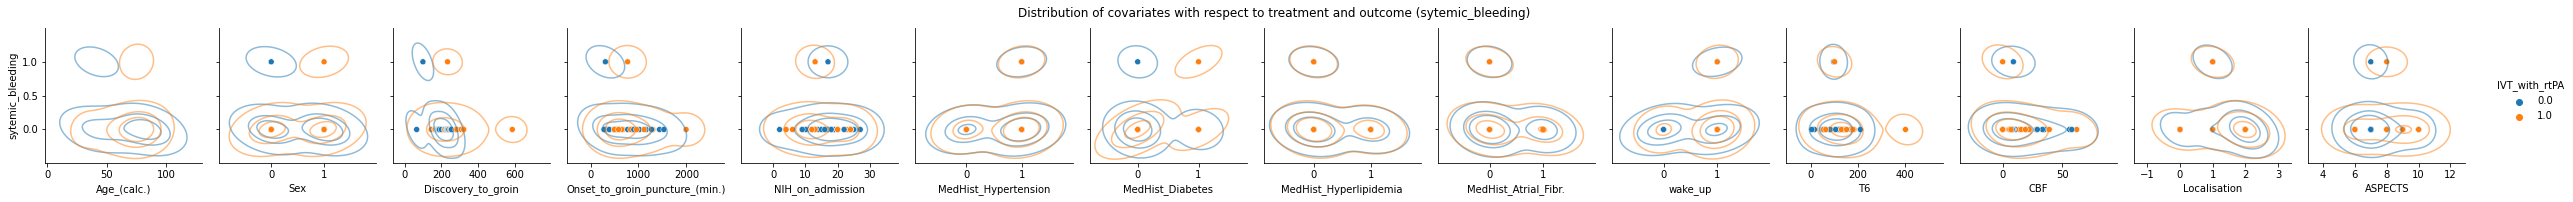

In [639]:
g = sns.pairplot(
    data,
    x_vars=covar_fields,
    y_vars=[outcome_var],
    hue=intervention_var,
    kind='scatter',
)
g.map(sns.kdeplot, alpha=.5, levels=4)

g.fig.suptitle(f'Distribution of covariates with respect to treatment and outcome ({outcome_var})', y=1.08)

plt.plot()

In [640]:
# g.savefig(f'{outcome_var}_covariates_distribution.png')

In [641]:
# sns.stripplot(x=outcome_var, y="propensity_score", hue='IVT_with_rtPA', data=data)
#

In [642]:
# sns.stripplot(x="index", y="propensity_score", hue='IVT_with_rtPA', data=data.reset_index())

